## Project members

Harshavardhan V N PES1UG19CS182 Section C\
Manogna PES1UG19CS158  Section C\
Devi PES1UG19CS139  Section C\
Jason PES1UG19CS195 Section C

## Project title

Knowledge based Restaurant Recommender Engine using multi-partite graph and Adam-Adar Link Predictor

### Libraries Used

networkx\
re\
numpy\
pandas\
transformers

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import json
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from transformers import AutoTokenizer, AutoModelForSequenceClassification

#tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis")

#model = AutoModelForSequenceClassification.from_pretrained("avichr/heBERT_sentiment_analysis")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Loading the Dataset

In [2]:
df=pd.read_csv('zomato.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

## EDA and Cleaning

In [4]:
df=df.head(50)
df=df.dropna()
df.rate = df.rate.replace("NEW", np.nan)
df.rate = df.rate.astype(str)
df.rate = df.rate.apply(lambda x: x.replace('/5',''))
df.rate = df.rate.apply(lambda x: float(x))
df['approx_cost(for two people)']=df['approx_cost(for two people)'].apply(lambda x: int(str(x).replace(',','')))
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [5]:
def categorise_ratings(rating):
    if(rating>=0 and rating<1):
        return("Bad")
    elif(rating>=1 and rating<2):
        return("Average")
    elif(rating>=2 and rating<3):
        return("Good")
    elif(rating>=3 and rating<4):
        return("Very Good")
    elif(rating>=4 and rating<=5):
        return("Excellent")
    else:
        return("Not known")

def categorise_cost(rating):
    rating=int(rating)
    if(rating>=0 and rating<300):
        return("Cheap")
    elif(rating>=300 and rating<700):
        return("Average")
    elif(rating>=700):
        return("Expensive")
    else:
        pass
    
'''def sentiment(text):
    
    sequences = [text]
    tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
    output = model(**tokens)
    vector=output.logits.detach().numpy()[0]
    index=list(vector).index(max(vector))
    if(index==0):
        return("Negetive")
    elif(index==1):
        return("Neutral")
    else:
        return("Positive")'''

def sentiment_extract(x):
    reviews=x.split("), (")
    sentiments=[]
    for review in reviews:
        sentiments.append(sentiment(re.search(".*(RATED)(.*)'",review).group(2)))
    l=[sentiments.count("Negetive")/len(sentiments),sentiments.count("Neutral")/len(sentiments),sentiments.count("Positive")/len(sentiments)]
    if(l.index(max(l))==0):
        return("Negetive")
    elif(l.index(max(l))==1):
        return("Neutral")
    else:
        return('Positive')

#df['reviews_list'] = df['reviews_list'].apply(lambda x: sentiment_extract(x))
df['rate'] = df['rate'].apply(lambda x: categorise_ratings(x))
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].apply(lambda x: categorise_cost(x))

In [6]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,Excellent,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",Expensive,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,Excellent,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",Expensive,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,Very Good,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",Expensive,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,Very Good,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",Average,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,Very Good,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",Average,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


## Multi-type Graph Construction

#### Here there are various types of nodes. For example restaurant, location, rating, cuisines are all nodes in the graph and all are interconnected with each other.

In [7]:
import networkx as nx
import time

G = nx.Graph(label="HOTELS")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['name'],votes=rowi['votes'],label="RESTAURANT")
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    G.add_node(rowi['location'],label="LOCATION")
    G.add_edge(rowi['name'], rowi['location'], label="LOCATED_AT")
    for element in rowi['cuisines'].split(","):
        G.add_node(element,label="CUISINE")
        G.add_edge(rowi['name'], element, label="CUSINES_SERVED")
    for element in rowi['rest_type'].split(","):
        G.add_node(element,label="RESTAURANT_TYPE")
        G.add_edge(rowi['name'], element, label="IS_OF_TYPE")
    for element in rowi['dish_liked'].split(","):
        G.add_node(element,label="GOOD_DISH")
        G.add_edge(rowi['name'], element, label="HAS_GOOD_DISH")
    G.add_node(rowi['listed_in(type)'],label="TYPE")
    G.add_edge(rowi['name'], rowi['listed_in(type)'], label="TYPE")
    G.add_node(rowi['approx_cost(for two people)'],label="APPROX_COST")
    G.add_edge(rowi['name'], rowi['approx_cost(for two people)'], label="APPROX_COST")
    G.add_node(rowi['rate'],label="RATING")
    G.add_edge(rowi['name'], rowi['rate'], label="HAS_RATING")
    #G.add_node(rowi['reviews_list'],label="REVIEW")
    #G.add_edge(rowi['name'], rowi['reviews_list'], label="HAS_REVIEWS")

print(" finish -- {} seconds --".format(time.time() - start_time))    

 iter 0 -- 0.0010173320770263672 seconds --
 finish -- 0.0220029354095459 seconds --


/home/harshavardhan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/harshavardhan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/harshavardhan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/harshavardhan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0, flags=flags)


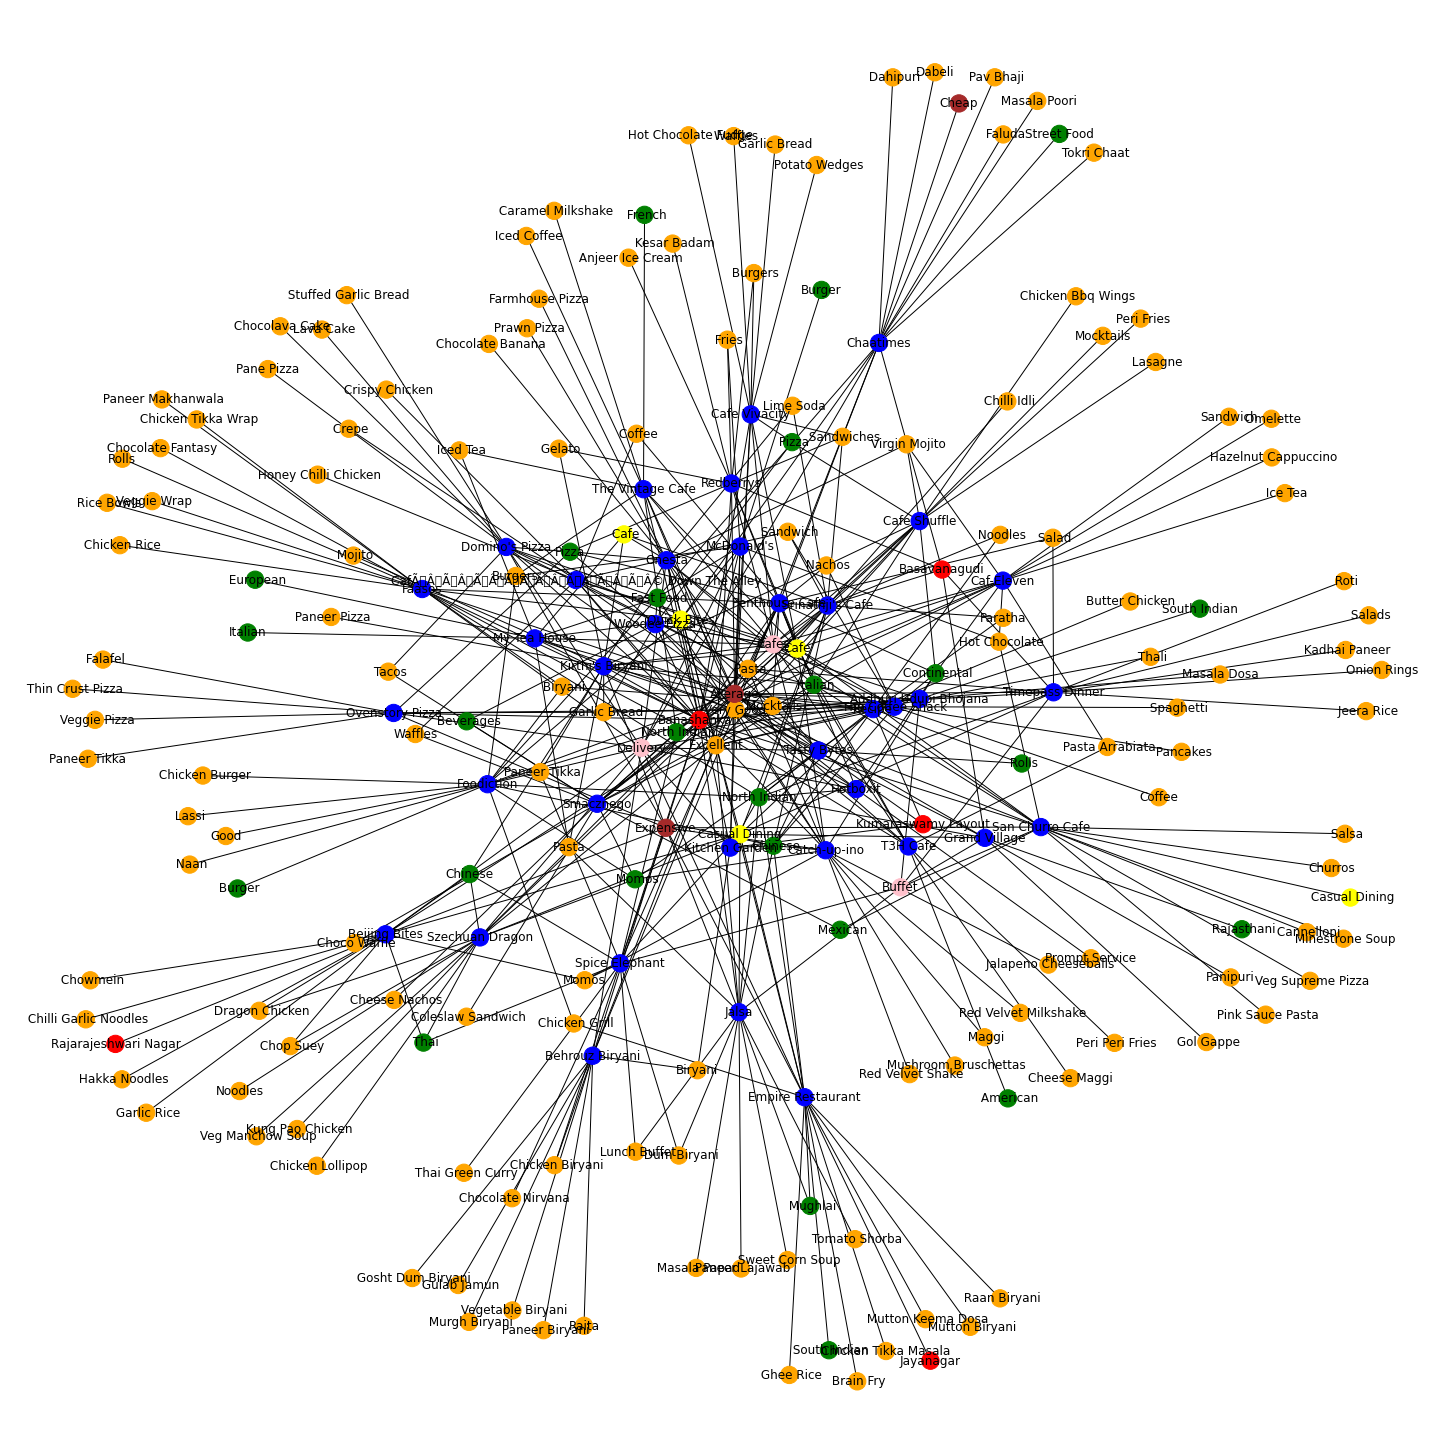

In [8]:
import matplotlib.pyplot as plt


colors=[]
for e in G.nodes():
    if G.nodes[e]['label']=="RESTAURANT":
        colors.append('blue')
    elif G.nodes[e]['label']=="LOCATION":
        colors.append('red')
    elif G.nodes[e]['label']=="CUISINE":
        colors.append('green')
    elif G.nodes[e]['label']=="RESTAURANT_TYPE":
        colors.append('yellow')
    elif G.nodes[e]['label']=="GOOD_DISH":
        colors.append('orange')    
    elif G.nodes[e]['label']=="RATING":
        colors.append('orange')
    elif G.nodes[e]['label']=="TYPE":
        colors.append('pink')
    elif G.nodes[e]['label']=="APPROX_COST":
        colors.append('brown')

plt.figure(3,figsize=(20,20)) 
nx.draw(G,with_labels=True,node_color=colors)
plt.show()

## Top 10

In [9]:
# Finding out the top 10 restaurants

print("\nTop 10 Restaurants\n")
top_restaurants=[]
for key in (nx.degree_centrality(G)):
    if(G.nodes[key]['label']=="RESTAURANT"):
        top_restaurants.append(key.strip())
print(*top_restaurants[:10],sep="\n")


Top 10 Restaurants

Jalsa
Spice Elephant
San Churro Cafe
Addhuri Udupi Bhojana
Grand Village
Timepass Dinner
Onesta
Penthouse Cafe
Smacznego
CafÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ© Down The Alley


In [10]:
print("\nTop 10 Dishes\n")
top_dishes=[]
for key in (nx.degree_centrality(G)):
    if(G.nodes[key]['label']=="GOOD_DISH"):
        top_dishes.append(key.strip())
print(*top_dishes[:10],sep="\n")


Top 10 Dishes

Pasta
Lunch Buffet
Masala Papad
Paneer Lajawab
Tomato Shorba
Dum Biryani
Sweet Corn Soup
Momos
Chocolate Nirvana
Thai Green Curry


In [11]:
print("\nTop 10 Cuisines\n")
top_cuisines=[]
for key in (nx.degree_centrality(G)):
    if(G.nodes[key]['label']=="CUISINE"):
        top_cuisines.append(key.strip())
print(*top_cuisines[:10],sep="\n")


Top 10 Cuisines

North Indian
Mughlai
Chinese
Chinese
North Indian
Thai
Mexican
Italian
South Indian
Rajasthani


In [12]:
print("\nTop 10 Locations\n")
top_locations=[]
for key in (nx.degree_centrality(G)):
    if(G.nodes[key]['label']=="LOCATION"):
        top_locations.append(key.strip())
print(*top_locations[:10],sep="\n")


Top 10 Locations

Banashankari
Basavanagudi
Jayanagar
Kumaraswamy Layout
Rajarajeshwari Nagar


In [13]:
print("\nTop Restaurant types\n")
top_type=[]
for key in (nx.degree_centrality(G)):
    if(G.nodes[key]['label']=="TYPE"):
        top_type.append(key)
print(*top_type[:10],sep="\n")


Top Restaurant types

Buffet
Cafes
Delivery


## Communities

In [14]:
communities_generator = nx.community.girvan_newman(G)

In [15]:
top_level_communities = next(communities_generator)
comm=sorted(map(sorted, top_level_communities))
for com in comm:
    print(*com[:10],sep="\n")
    print('\n\n')

 American
 Anjeer Ice Cream
 Beverages
 Biryani
 Brain Fry
 Burger
 Burgers
 Cafe
 Cannelloni
 Caramel Milkshake



 Dahipuri
 Faluda
 Masala Poori
 Pav Bhaji
 Tokri Chaat
Chaatimes
Cheap
Dabeli
Street Food





In [16]:
medium_level_communities = next(communities_generator)
comm=sorted(map(sorted, medium_level_communities))
for com in comm:
    print(*com[:10],sep="\n")
    print('\n\n')

 American
 Anjeer Ice Cream
 Beverages
 Biryani
 Burger
 Burgers
 Cafe
 Cannelloni
 Caramel Milkshake
 Casual Dining



 Brain Fry
 Chicken Grill
 Ghee Rice
 Mughlai
 Mutton Biryani
 Mutton Keema Dosa
 Raan Biryani
 South Indian
Chicken Tikka Masala
Empire Restaurant



 Dahipuri
 Faluda
 Masala Poori
 Pav Bhaji
 Tokri Chaat
Chaatimes
Cheap
Dabeli
Street Food





In [17]:
bottom_level_communities = next(communities_generator)
comm=sorted(map(sorted, bottom_level_communities))
for com in comm:
    print(*com[:10],sep="\n")
    print('\n\n')

 American
 Anjeer Ice Cream
 Beverages
 Biryani
 Burger
 Burgers
 Cafe
 Cannelloni
 Caramel Milkshake
 Casual Dining



 Brain Fry
 Chicken Grill
 Ghee Rice
 Mughlai
 Mutton Biryani
 Mutton Keema Dosa
 Raan Biryani
 South Indian
Chicken Tikka Masala
Empire Restaurant



 Chicken Lollipop
 Chilli Garlic Noodles
 Chop Suey
 Chowmein
 Dragon Chicken
 Garlic Rice
 Hakka Noodles
 Kung Pao Chicken
 Thai
 Veg Manchow Soup



 Dahipuri
 Faluda
 Masala Poori
 Pav Bhaji
 Tokri Chaat
Chaatimes
Cheap
Dabeli
Street Food





### Interpretation

#### As we can see, as we further go down clustering , each of the communities represent a similar type of cuisines , dished and hotels serving them.




#### Example : 

#### Interpretted commnunities:

**Chaat dishes and restaurants serving them** \
**Chicken related dishes and restaurants serving them** \
**Cafe, Desert dishes and restaurants serving them** 


## Building the recommender Engine

### The recommender engine is built using the multigraph that was generated before and using the adamic adar link prediction.



In [18]:
import math

def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="RESTAURANT":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    
    #Adamic Adar Link Prediction using the common neighbours
    
    """ Not using the networkx module to calculate the values
        as the function cannot calculate the it for the kind of 
        graphs where the nodes are of various types."""
    for key, values in commons_dict.items():
        w=0.0
        #print(key,values)
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

## Testing the recommender engine

In [19]:
#Calling the recommender engine
result=get_recommendation('Spice Elephant')
print(result)

Jalsa                                                 4.997941
Beijing Bites                                         3.410415
Szechuan Dragon                                       2.751732
Onesta                                                2.562840
Addhuri Udupi Bhojana                                 1.775278
Behrouz Biryani                                       1.749623
Catch-up-ino                                          1.651461
Kirthi's Biryani                                      1.462570
San Churro Cafe                                       1.299333
Empire Restaurant                                     1.247512
The Vintage Cafe                                      1.217167
Penthouse Cafe                                        1.120145
Grand Village                                         0.992405
Timepass Dinner                                       0.992405
Recipe                                                0.813218
Domino's Pizza                                        0

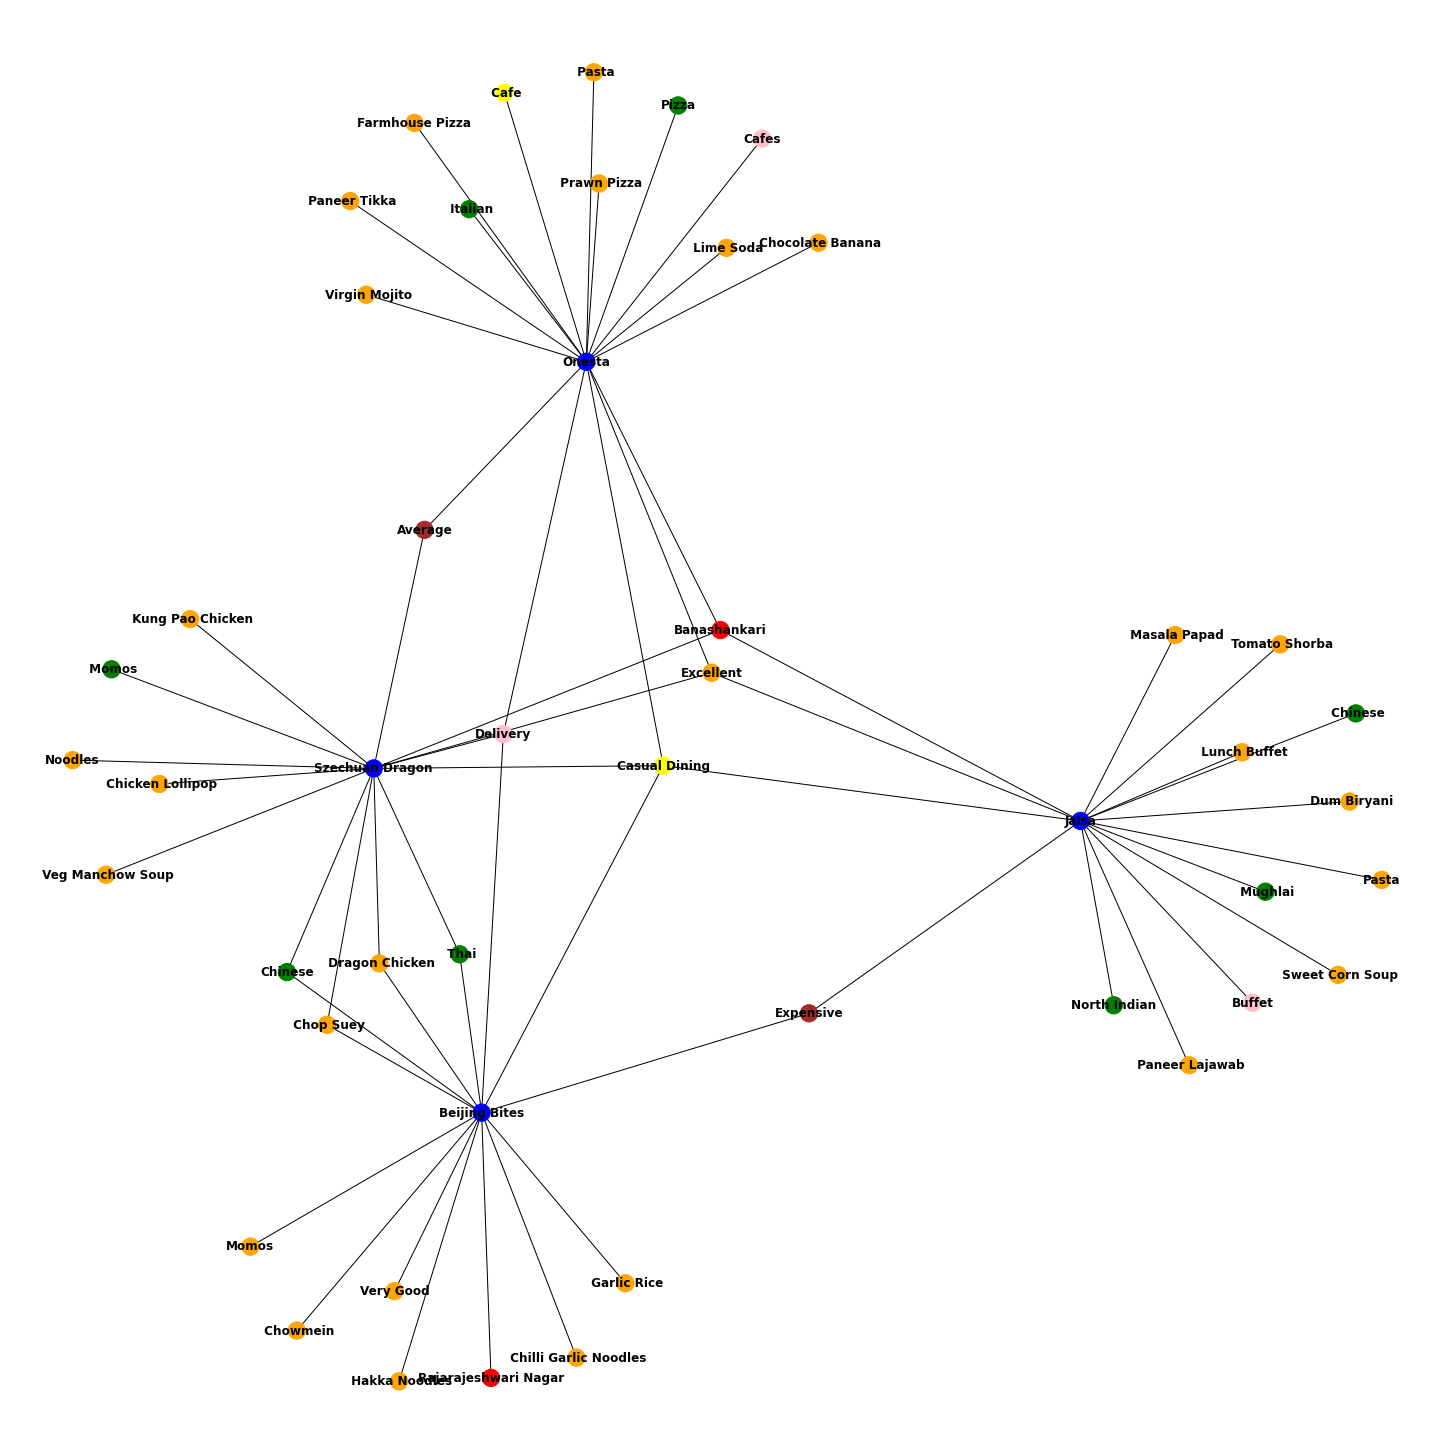

In [20]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="RESTAURANT":
            colors.append('blue')
        elif G.nodes[e]['label']=="LOCATION":
            colors.append('red')
        elif G.nodes[e]['label']=="CUISINE":
            colors.append('green')
        elif G.nodes[e]['label']=="RESTAURANT_TYPE":
            colors.append('yellow')
        elif G.nodes[e]['label']=="GOOD_DISH":
            colors.append('orange')    
        elif G.nodes[e]['label']=="RATING":
            colors.append('orange')
        elif G.nodes[e]['label']=="TYPE":
            colors.append('pink')
        elif G.nodes[e]['label']=="APPROX_COST":
            colors.append('brown')

    plt.figure(3,figsize=(20,20)) 
    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()
    
#Visualizing the neighbourhood of the predicted restaurants to understand the similarities

reco=list(result.index[:4].values)
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

This output shows the common nodes between the input restaurant and recommended restaurants.